In [59]:
import math

import snntorch as snn
from snntorch import spikegen
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from aes_commons import *
import random

In [ ]:
import matplotlib
matplotlib.use("pgf")
font_size = 13
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'axes.titlesize': font_size,
    'font.size': font_size,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size' : font_size,
    'axes.labelsize': font_size,
    'legend.fontsize': font_size,
    'legend.title_fontsize': font_size,
    'text.usetex': True,
})

In [60]:
config = {
    # Meta
    "no_epochs": 1,
    "batch_size" : 10_000,

    # SNN config
    "num_steps": 25,
    "beta": 0.95,
    
    # Network dimentions  
    "num_inputs": 128,
    "num_spiking1": 128,
    "num_spiking2": 128,
    "num_hidden_out": 256,
    "num_outputs": 128
}

In [61]:


def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result

def bytes_to_float_array2(input, size):
    assert isinstance(input, bytes)
    input = bin(int.from_bytes(input, 'little'))
    input = input[2:]
    output = torch.zeros(size, dtype=torch.float32)
    for i, b in enumerate(input):
        output[i] = float(b)
    return output

print(bytes_to_float_array({uint8(6)}))

@dataclass
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_config():        
        return CryptoDataset(no_bytes=config["num_inputs"]//8, batch_size = config["batch_size"])
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_sub_byte(self):
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = mix_columns(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration

from typing import Any

@dataclass()
class ArbitraryFunction:
    func: Any
    xs: Any
    batch_size = config["batch_size"]
    n = 0

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < config["batch_size"]:
            self.n += 1
            x = self.xs[self.n - 1]
            y = self.func(x)
            return torch.FloatTensor(bytes_to_float_array2(bytes(x), 128)) , torch.FloatTensor(bytes_to_float_array2(bytes(y), 128))
        else:
            raise StopIteration
    
    

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [62]:

def int_to_float_array(val:int)->List[float]:
    
    input = bin(val)
    result = np.zeros(128)
    input = input[2:]
    input = input[::-1]
    for i, bit in enumerate(input):
        result[i] = float(bit)
    
    return result


def x_square(input:int)->int:
     
    return input**2

@dataclass
class XSquared:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_config():        
        return XSquared(no_bytes=config["num_inputs"]//8,batch_size = config["batch_size"])
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_x_square(self):
        
        label = random.getrandbits(64)
        # label = 4
        input = x_square(label) 
        return (torch.FloatTensor(int_to_float_array(input)),torch.FloatTensor(int_to_float_array(label)))
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_x_square()
        else:
            raise StopIteration

In [63]:

class SNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_hidden_out"])
        self.drop = nn.Dropout(p=0.1, inplace=False)
        self.fc4 = nn.Linear(config["num_hidden_out"], config["num_outputs"])

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += spikes2
        
        # spike_sum = self.sigmoid(spike_sum)
        out = self.fc3(spike_sum)
        out = self.relu(out)
        out = self.drop(out)
        out = self.relu(out)
        out = self.fc4(out)
        # out = self.relu(out)
        
        # Maybe another dense layer
        
        return self.sigmoid(out)


In [64]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(config['num_inputs'], config['num_hidden_out'])
        self.fc2 = nn.Linear(config['num_hidden_out'], config['num_hidden_out'])
        self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
        self.fc3 = nn.Linear(config['num_hidden_out'], config['num_outputs'])

    def forward(self, x):
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(F.relu(x)))
        return x



In [65]:
spiking = SNNModel()
standard = NNModel()
spiking, standard

(SNNModel(
   (fc0): Linear(in_features=128, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=128, bias=True)
   (lif1): Leaky()
   (fc2): Linear(in_features=128, out_features=256, bias=True)
   (lif2): Leaky()
   (fc3): Linear(in_features=256, out_features=256, bias=True)
   (drop): Dropout(p=0.1, inplace=False)
   (fc4): Linear(in_features=256, out_features=128, bias=True)
   (sigmoid): Sigmoid()
   (relu): ReLU()
 ),
 NNModel(
   (fc1): Linear(in_features=128, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (fc3): Linear(in_features=256, out_features=128, bias=True)
 ))

In [66]:
from torch.utils.data import DataLoader
# train_loader = CryptoDataset.from_config()
train_loader = XSquared.from_config()
test_loader = XSquared.from_config()

In [67]:
# import snntorch.spikeplot as splt

# # Iterate through minibatches
# data = iter(train_loader)
# data_it, targets_it = next(data)

# # Spiking Data
# spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
# spike_data.size()

In [68]:
# spike_data = spike_data[:]
# spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
# fig = plt.figure(facecolor="w", figsize=(10, 5))
# ax = fig.add_subplot(111)
# splt.raster(spike_data_sample_plot, ax, s=1.5)

In [69]:
loss_func = nn.L1Loss() # Idk
snn_optimizer = torch.optim.Adam(spiking.parameters(), lr=0.0005)
nn_optimizer = torch.optim.Adam(standard.parameters(), lr=0.0005)
nn_loss_hist = []
snn_loss_hist = []

In [70]:
from tqdm import tqdm
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader), total=config["batch_size"], desc=f"Epoch {epoch}"):
        spiking.train()
        standard.train()
        
        # forward
        output = spiking(x)
        snn_loss = loss_func(output, y)
        
        # Gradient calculation + weight update
        snn_optimizer.zero_grad()
        snn_loss.backward()
        snn_optimizer.step()
        
        # forward
        output = standard(x)
        nn_loss = loss_func(output, y)
        # Gradient calculation + weight update
        nn_optimizer.zero_grad()
        nn_loss.backward()
        nn_optimizer.step()

        # Store loss history for future plotting
        snn_loss_hist.append(snn_loss.item())
        nn_loss_hist.append(nn_loss.item())

Epoch 0:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 10000/10000 [01:10<00:00, 141.15it/s]


In [92]:
def plot(name):
    plt.savefig(name)
    plt.show()

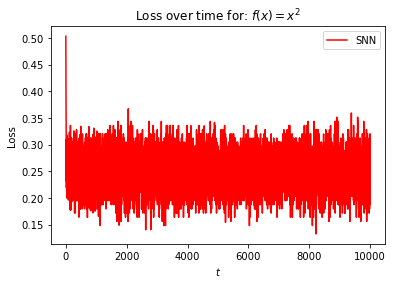

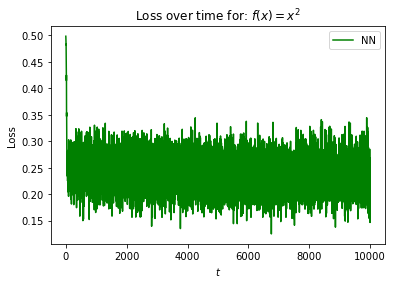

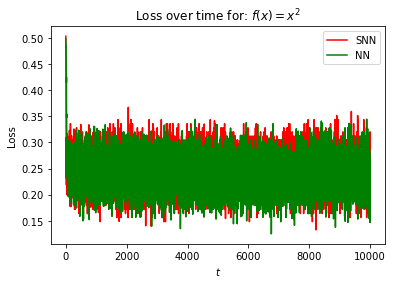

In [122]:
plt.title("Loss over time for: $f(x)=x^2$")
plt.ylabel("Loss")
plt.xlabel("$t$")
plt.plot(snn_loss_hist, color='r', label="SNN")
plt.legend()
plot("xsqr_snn_loss_history.pgf")
plt.title("Loss over time for: $f(x)=x^2$")
plt.ylabel("Loss")
plt.xlabel("$t$")
plt.plot(nn_loss_hist,color='g', label='NN')
plt.legend()
plot("xsqr_nn_loss_history.pgf")
plt.title("Loss over time for: $f(x)=x^2$")
plt.ylabel("Loss")
plt.xlabel("$t$")
plt.plot(snn_loss_hist, color='r', label='SNN')
plt.plot(nn_loss_hist, color='g', label='NN')
plt.legend()
plot("xsqr_both_loss_history.pgf")

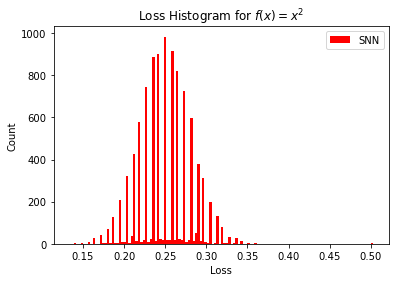

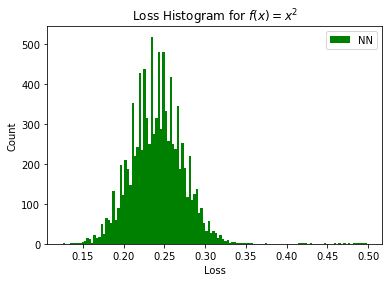

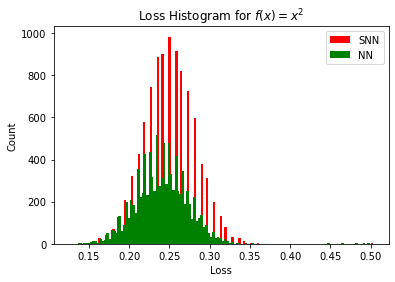

In [123]:
plt.title('Loss Histogram for $f(x)=x^2$')
plt.xlabel('Loss')
plt.ylabel('Count')
plt.hist(snn_loss_hist,bins=128, color='r', label='SNN')
plt.legend()
plot("xsqr_snn_loss_histogram.pgf")
plt.title('Loss Histogram for $f(x)=x^2$')
plt.xlabel('Loss')
plt.ylabel('Count')
plt.hist(nn_loss_hist,bins=128, color='g', label='NN')
plt.legend()
plot("xsqr_nn_loss_histogram.pgf")
plt.title('Loss Histogram for $f(x)=x^2$')
plt.xlabel('Loss')
plt.ylabel('Count')
plt.hist(snn_loss_hist,bins=128, color='r', label='SNN')
plt.hist(nn_loss_hist,bins=128, color='g', label='NN')
plt.legend()
plot("xsqr_both_loss_histogram.pgf")

In [85]:
import numpy as np

def count_bad(input: torch.Tensor, output: torch.Tensor):
    assert len(input) == len(output)
    input = input.detach().numpy()
    output = output.detach().numpy()
    input, output = np.clip(input, 0, 1), np.clip(output, 0, 1)
    input, output = np.around(input, 0) , np.around(output, 0)
    diff = np.abs(input - output)
    return sum(diff)


a = torch.tensor([0.23, .33, .66])
b = torch.tensor([0.33, .46, .70])
c = torch.tensor([.55, .12, .1])
assert count_bad(a,b) == 0
assert count_bad(a,c) == 2

In [86]:
spiking_global_loss = .0
standard_global_loss = .0
samples = 1000
spiking.eval()
standard.eval()
with torch.no_grad():
    for index, (x, y) in enumerate(test_loader):
        outputs = spiking(x)
        spiking_global_loss += count_bad(outputs, y) / config["num_outputs"]
        
        outputs = standard(x)
        standard_global_loss += count_bad(outputs, y) / config["num_outputs"]

        if index == samples:
            break

print("Spiking incorrect: ", config["num_outputs"] * spiking_global_loss / samples)
print("Standard incorrext: ", config["num_outputs"] * standard_global_loss / samples)

/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Spiking incorrect:  32.058
Standard incorrext:  30.378


In [75]:
import math

def binomial(k, n, p=0.5):
    """Binomial distribution with 

    Args:
        k (int): Number of successes
        n (int): Number of trials
        p (float, optional Probability of success. Defaults to 0.5.

    Returns:
        (float): Probability of exactly k successes
    """
    return (math.comb(n,k) * (p**k) * ((1-p)**(n-k)))

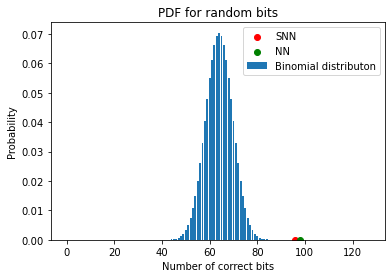

In [124]:
plt.title("PDF for random bits")
plt.bar(list(range(config["num_outputs"])), [binomial(i, config["num_outputs"]) for i in range(config["num_outputs"])], label='Binomial distributon')

plt.ylabel("Probability")
plt.xlabel("Number of correct bits")
spiking_ok = config["num_outputs"] - int(config["num_outputs"] * spiking_global_loss / samples)
plt.scatter([spiking_ok],binomial(int(spiking_ok), config["num_outputs"]), color='r', label='SNN')

standard_ok = config["num_outputs"] - int(config["num_outputs"] * standard_global_loss / samples)
plt.scatter([standard_ok],binomial(int(standard_ok), config["num_outputs"]), color='g', label='NN')
plt.legend()
plot("xsqr_binomial.pgf")